# Introduction

Electric vehicle (EV) adoption is rising, making accessible and reliable charging infrastructure a necessity. EnBW, as a key provider in Germany, plays a significant role in meeting this demand. However, challenges remain in infrastructure development, especially in underserved rural areas.

This project aims to analyze and predict EnBW charging accessibility challenges across Germany, focusing on search interest for **EnBW Ladestation** and **EnBW Ladekarte**. By using Google Trends data and charging station density information, we can identify potential accessibility gaps and forecast future demand.

### Research Question

- **Where are the largest gaps in EnBW charging station coverage across Germany, and how does this impact accessibility for rural versus urban residents?**

### Project Objective

The objective of this project is to assess EnBW EV charging accessibility by:

1. **Analyzing consumer search interest** specifically for EnBW charging.
2. **Identifying high-demand regions** with low infrastructure density.
3. **Building a predictive model** to forecast demand, aiding proactive planning for EnBW infrastructure growth in underserved areas.

### Assumptions About the Data

#### 1. Population Estimates and Region Classification
- Population data is assumed to be accurate, and regions are classified into urban and rural based on a population density threshold (300 people per km², according to https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Archive:Urban-rural_typology)).
- This threshold may be generalized, so it’s important to validate it against German standards for rural vs. urban classification if higher precision is needed.

#### 2. Operator Identification for EnBW Charging Stations
- An assumption is made that a particular `OperatorID` in the charging stations dataset represents EnBW stations.
- This ID should be verified with official EnBW data sources if available, as any discrepancy could affect the station density analysis.

#### 3. Search Interest as a Proxy for Demand
- Google Trends data for specific keywords is used as a proxy for demand.
- While it serves as an indicator, it may not capture all factors influencing actual EV charging demand (e.g., regional EV adoption rates, seasonal factors).

### Sources

- https://openchargemap.org/site (API)
- https://trends.google.de/trends/ (API)
- https://www.kontur.io/geospatial-datasets-catalog/ (Geospatial dataset Germany "kontur_population_DE_20231101.gpkg" )


## Step 1: Data Collection
### Google Trends Data

In this section, data is gathered from Google Trends to analyze search interest in EnBW and other charging-related keywords across Germany. Additionally, charging station data from Open Charge Map API is fetched, focusing on station locations and density to later assess gaps in infrastructure.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import warnings
import requests
import contextily as ctx
import osmnx as ox
from pytrends.request import TrendReq
from pyrosm import OSM
from shapely.geometry import Point
from scipy.spatial import KDTree
from tqdm import tqdm

# Scikit-Learn modules
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# XGBoost
from xgboost import XGBRegressor

# Ignore warnings
warnings.filterwarnings("ignore")


The Google Trends data acts as a proxy for demand by showing areas where people are actively searching for EV and EnBW charging options. By comparing search interest with current station density, potential infrastructure gaps where interest is high but charging facilities are lacking, could be highlighted.

In [2]:
# Initialize Google Trends API
pytrends = TrendReq(hl='de', tz=360) #set language to German

# Define broader and EnBW-specific keyword batches
broad_keyword_batches = [
    ["Ladestation in meiner Nähe", "Verfügbarkeit Ladestation", "Elektroauto Ladestation finden", "Schnelladestation"],
    
]
enbw_keyword_batches = [
    ["EnBW Ladestation", "EnBW Schnellladestation"],
    
]

# Function to collect trends data
def fetch_trends_data(keyword_batches):
    all_trends_data = pd.DataFrame()
    for batch in keyword_batches:
        pytrends.build_payload(batch, cat=0, timeframe='today 12-m', geo='DE')
        trends_data = pytrends.interest_over_time().drop(columns=['isPartial'], errors='ignore')
        all_trends_data = pd.concat([all_trends_data, trends_data], axis=1)
    return all_trends_data

# Collect and save broader trends
all_trends_data = fetch_trends_data(broad_keyword_batches)
all_trends_data.to_csv('germany_ev_charging_keywords_trends.csv')

# Collect and save EnBW-specific trends
enbw_trends_data = fetch_trends_data(enbw_keyword_batches)
enbw_trends_data.to_csv('germany_enbw_ev_charging_trends.csv')


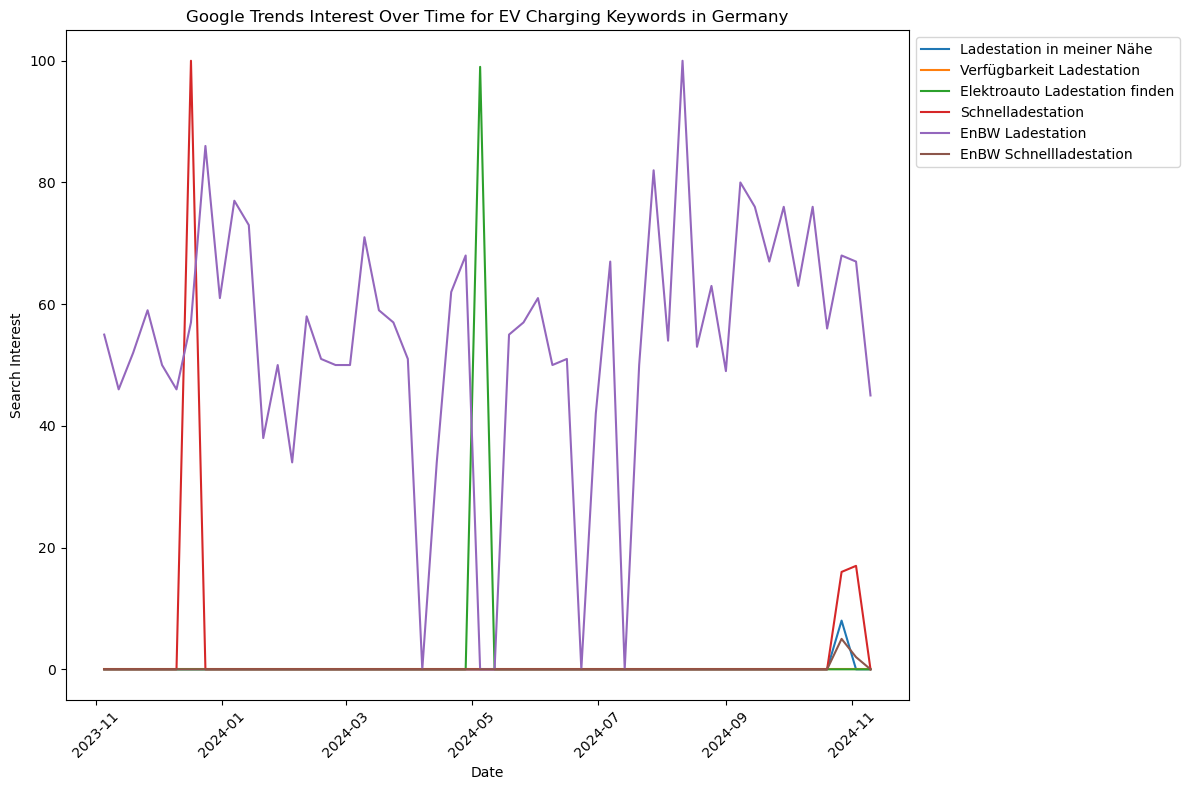

In [3]:
# Load trends data
all_trends_data = pd.read_csv('germany_ev_charging_keywords_trends.csv', index_col=0, parse_dates=True)
enbw_trends_data = pd.read_csv('germany_enbw_ev_charging_trends.csv', index_col=0, parse_dates=True)

# Combine broader and EnBW-specific trends data
combined_trends_data = pd.concat([all_trends_data, enbw_trends_data], axis=1)

# Plot the combined data
plt.figure(figsize=(12, 8))

# Plot each keyword as a separate line
for column in combined_trends_data.columns:
    plt.plot(combined_trends_data.index, combined_trends_data[column], label=column)

# Customize the plot
plt.title("Google Trends Interest Over Time for EV Charging Keywords in Germany")
plt.xlabel("Date")
plt.ylabel("Search Interest")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Charging Infrastructure Data

Use the Open Charge Map API to collect charging station data:

In [4]:
# API setup and request
api_url = "https://api.openchargemap.io/v3/poi/"
params = {
    'countrycode': 'DE', 'maxresults': 5000, 'compact': True, 'verbose': False, 'key': 'aa161c61-b106-4270-bf08-9ee6fce32160'
}
response = requests.get(api_url, params=params)
charging_stations_df = pd.json_normalize(response.json()).dropna(subset=['AddressInfo.Latitude', 'AddressInfo.Longitude'])
charging_stations_df.to_csv('germany_charging_stations.csv')


<Figure size 1000x1000 with 0 Axes>

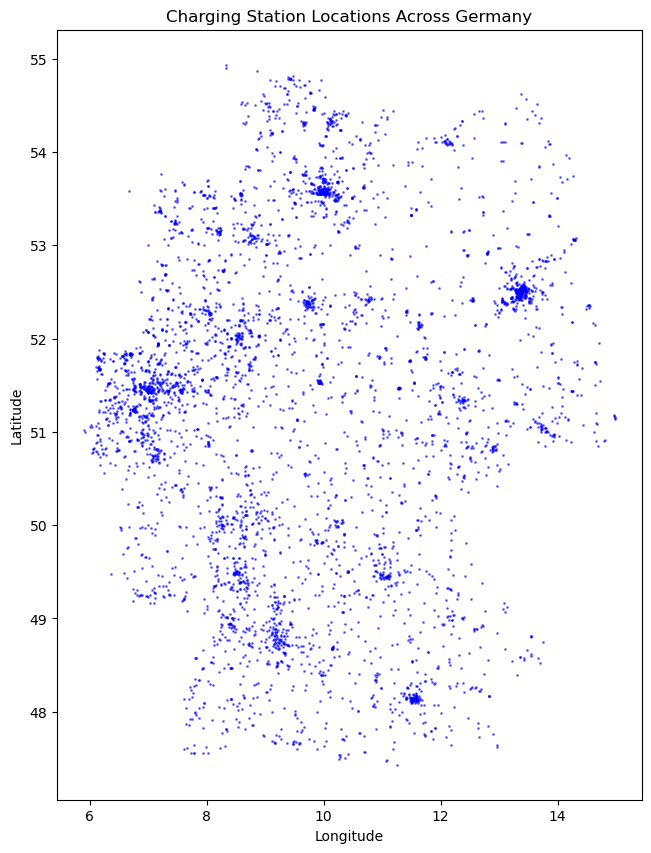

In [5]:
# Load charging stations data
charging_stations_df = pd.read_csv('germany_charging_stations.csv')

# Create geometry column with coordinates for GeoDataFrame
charging_stations_df['geometry'] = charging_stations_df.apply(
    lambda row: Point(row['AddressInfo.Longitude'], row['AddressInfo.Latitude']), axis=1
)

# Convert DataFrame to GeoDataFrame
germany_charging_stations = gpd.GeoDataFrame(charging_stations_df, geometry='geometry', crs="EPSG:4326")

# Plot charging station locations on a map of Germany
plt.figure(figsize=(10, 10))
base = germany_charging_stations.plot(markersize=1, color='blue', alpha=0.5, figsize=(10, 10))
plt.title("Charging Station Locations Across Germany")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [6]:
# Check unique values in the 'OperatorID' column
print(charging_stations_df['OperatorID'].unique())

# Assuming EnBW's OperatorID is known (replace 127 with EnBW's actual ID if different)
enbw_operator_id = 127  # Replace with the actual ID for EnBW if different

# Filter for EnBW charging stations based on 'OperatorID'
enbw_stations_df = charging_stations_df[charging_stations_df['OperatorID'] == enbw_operator_id]

# Verify the filtering
print(f"Total EnBW charging stations found: {len(enbw_stations_df)}")

# Optional: Plot or analyze EnBW charging stations as needed


[1.270e+02 1.000e+00 1.560e+02 3.714e+03       nan 3.800e+01 3.534e+03
 3.299e+03 3.538e+03 3.796e+03 3.752e+03 2.240e+02 8.600e+01 3.504e+03
 5.000e+00 1.030e+02 1.380e+02 3.341e+03 3.758e+03 3.455e+03 4.500e+01
 1.240e+03 3.571e+03 3.464e+03 2.200e+02 1.010e+02 3.523e+03 1.210e+02
 1.800e+02 3.582e+03 6.900e+01 1.360e+02 3.479e+03 3.447e+03 1.050e+02
 3.261e+03 3.680e+03 2.350e+02 2.340e+02 3.437e+03 4.600e+01 2.244e+03
 2.140e+02 2.300e+01 3.492e+03 1.790e+02 3.292e+03 7.400e+01 3.297e+03
 3.429e+03 3.369e+03 4.400e+01 3.423e+03 4.800e+01 3.466e+03 7.200e+01
 3.403e+03 1.530e+02 1.540e+02 1.700e+02 3.396e+03 1.890e+02 1.280e+02
 1.240e+02 3.253e+03 3.325e+03 1.480e+02 1.750e+02 1.430e+02 1.660e+02
 1.520e+02 1.300e+02 1.320e+02 1.610e+02 1.400e+02 1.590e+02 1.840e+02
 1.550e+02 1.720e+02 1.090e+02 3.443e+03 2.243e+03 1.880e+02 1.650e+02
 1.630e+02 2.241e+03 1.390e+02 1.220e+02 1.510e+02 2.250e+02 1.950e+02
 3.351e+03]
Total EnBW charging stations found: 198


In [7]:
# Display unique OperatorID values with counts
print(charging_stations_df['OperatorID'].value_counts())


OperatorID
45.0      475
69.0      331
86.0      301
105.0     236
127.0     198
         ... 
138.0       1
3504.0      1
3752.0      1
3538.0      1
3351.0      1
Name: count, Length: 91, dtype: int64


In [8]:
unique_stations = enbw_stations_df[['AddressInfo.Latitude', 'AddressInfo.Longitude']].drop_duplicates()
print(f"Unique EnBW charging stations found: {len(unique_stations)}")


Unique EnBW charging stations found: 192


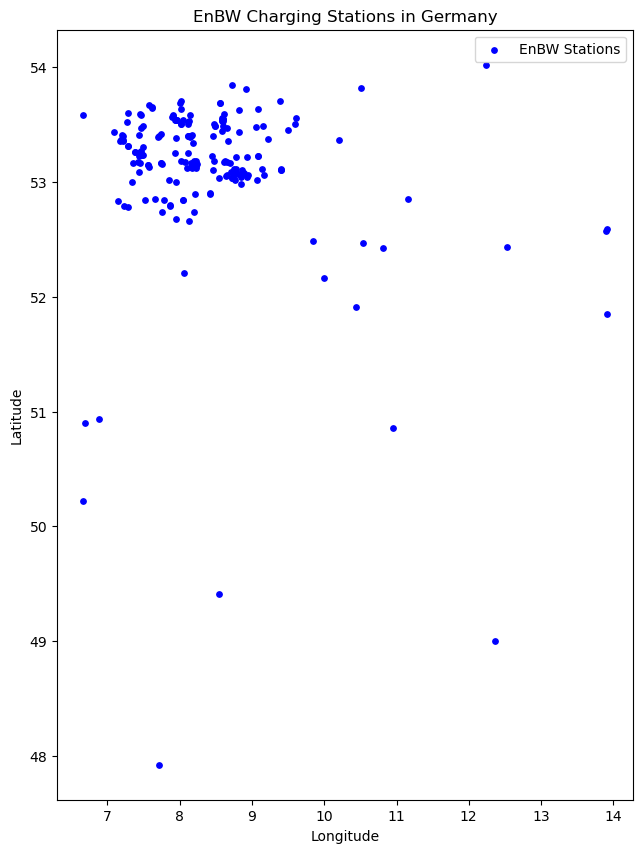

In [9]:
# Convert EnBW stations to a GeoDataFrame for mapping
enbw_stations_gdf = gpd.GeoDataFrame(
    enbw_stations_df,
    geometry=gpd.points_from_xy(enbw_stations_df['AddressInfo.Longitude'], enbw_stations_df['AddressInfo.Latitude']),
    crs="EPSG:4326"  # WGS 84
)

# Plot EnBW charging stations on a map of Germany
fig, ax = plt.subplots(figsize=(10, 10))
enbw_stations_gdf.plot(ax=ax, markersize=15, color="blue", label="EnBW Stations")
plt.title("EnBW Charging Stations in Germany")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


## Step 2: Data Preprocessing

This part of the notebook covers the cleaning and organization of trends and station data. Missing values are handled, and data is resampled to monthly averages to align with temporal trends analysis. GeoDataFrames are created for mapping and geospatial analyses.

In [10]:
# Load data
trends_data = pd.read_csv('germany_enbw_ev_charging_trends.csv', index_col=0, parse_dates=True)
charging_data = pd.read_csv('germany_charging_stations.csv')

# Resample Google Trends data to monthly averages
monthly_trends = trends_data.resample('M').mean()

# Handle missing values
monthly_trends.fillna(0, inplace=True)
charging_data.dropna(subset=['AddressInfo.Latitude', 'AddressInfo.Longitude'], inplace=True)


## Step 3: Preprocessing and Exploratory Data Analysis (EDA) / Geospatial Analysis (Demand-Supply Gap Analysis)

Here, an initial examination of demand (search interest) and supply (station density) across Germany is being performed. Using clustering for region classification and population density thresholds, it is distinguished between rural and urban areas to highlight areas of high demand and low supply.


**Demand Analysis**

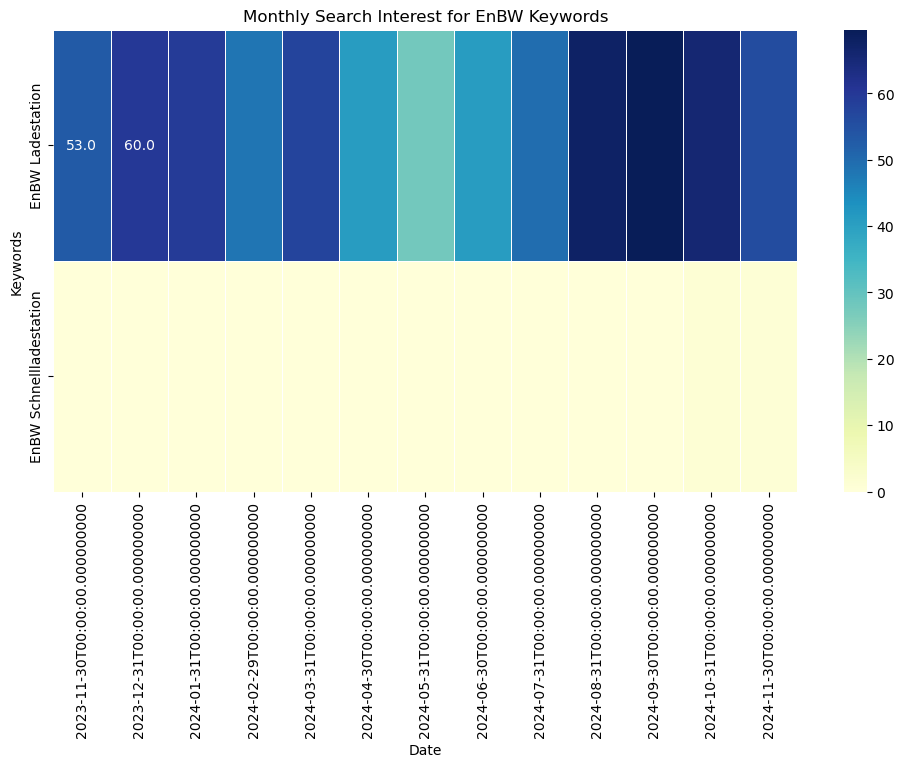

In [11]:
# Plot search interest trends
plt.figure(figsize=(12, 6))
sns.heatmap(monthly_trends.T, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5)
plt.title("Monthly Search Interest for EnBW Keywords")
plt.xlabel("Date")
plt.ylabel("Keywords")
plt.show()


**Supply Analysis**

In [12]:
# Assuming charging_data has regional classifications
charging_data['Region'] = KMeans(n_clusters=50).fit_predict(charging_data[['AddressInfo.Latitude', 'AddressInfo.Longitude']])
station_counts = charging_data.groupby('Region').size().reset_index(name='StationCount')

# Merge with population data for density calculation
population_data = pd.DataFrame({'Region': range(50), 'Population': [10000] * 50})
region_data = station_counts.merge(population_data, on='Region', how='left')
region_data['station_density_per_1000'] = region_data['StationCount'] / (region_data['Population'] / 1000)

**Demand-Supply Gap Analysis**

Ensure population and geometry columns exist in germany_regions.
Calculate area_km2 for each region and then use it to calculate population_density.
Classify regions based on population_density


In [13]:
# Load population density GeoDataFrame
germany_regions = gpd.read_file('kontur_population_DE_20231101.gpkg', layer='population')

# Calculate area and population density if the GeoDataFrame's CRS is appropriate
if germany_regions.crs.is_geographic:
    germany_regions = germany_regions.to_crs(epsg=32632)  # UTM for Germany

germany_regions['area_km2'] = germany_regions['geometry'].area / 1e6
germany_regions['population_density'] = germany_regions['population'] / germany_regions['area_km2']
urban_threshold = 300
germany_regions['classification'] = germany_regions['population_density'].apply(
    lambda x: 'urban' if x >= urban_threshold else 'rural'
)


In [14]:
# Display the relevant columns to verify data structure and classification
print(germany_regions[['h3', 'population', 'area_km2', 'population_density', 'classification']].head())

# Assuming monthly_trends also has 'h3' identifiers or needs to be joined by region:
urban_density = germany_regions[germany_regions['classification'] == 'urban']['population_density'].mean()
rural_density = germany_regions[germany_regions['classification'] == 'rural']['population_density'].mean()

print("Average station density in urban regions:", urban_density)
print("Average station density in rural regions:", rural_density)


                h3  population  area_km2  population_density classification
0  881faedb6dfffff        19.0  1.608534           11.811996          rural
1  881faedb69fffff       143.0  1.608868           88.882362          rural
2  881faedb67fffff      1051.0  1.608467          653.417130          urban
3  881faedb65fffff       485.0  1.608334          301.554318          urban
4  881faedb63fffff        24.0  1.608801           14.917943          rural
Average station density in urban regions: 783.6906987995065
Average station density in rural regions: 49.09421357793344


In [15]:
print("Columns in monthly_trends DataFrame:", monthly_trends.columns)


Columns in monthly_trends DataFrame: Index(['EnBW Ladestation', 'EnBW Schnellladestation'], dtype='object')


In [16]:
monthly_trends['h3'] = germany_regions['h3'].values[:len(monthly_trends)]


In [17]:
print("Columns in monthly_trends:", monthly_trends.columns)
print("Columns in germany_regions:", germany_regions.columns)


Columns in monthly_trends: Index(['EnBW Ladestation', 'EnBW Schnellladestation', 'h3'], dtype='object')
Columns in germany_regions: Index(['h3', 'population', 'geometry', 'area_km2', 'population_density',
       'classification'],
      dtype='object')


In [18]:
# Join germany_regions with monthly_trends on the 'h3' column
monthly_trends = monthly_trends.merge(germany_regions[['h3', 'classification']], on='h3', how='left')


In [19]:
print("Columns in monthly_trends after merging:", monthly_trends.columns)
print(monthly_trends.head())  # Verify the classification column


Columns in monthly_trends after merging: Index(['EnBW Ladestation', 'EnBW Schnellladestation', 'h3', 'classification'], dtype='object')
   EnBW Ladestation  EnBW Schnellladestation               h3 classification
0             53.00                      0.0  881faedb6dfffff          rural
1             60.00                      0.0  881faedb69fffff          rural
2             59.50                      0.0  881faedb67fffff          urban
3             48.25                      0.0  881faedb65fffff          urban
4             57.60                      0.0  881faedb63fffff          rural


In [20]:
# Calculate demand averages for urban and rural classifications
avg_demand_urban = monthly_trends[monthly_trends['classification'] == 'urban'].select_dtypes(include='number').mean()
avg_demand_rural = monthly_trends[monthly_trends['classification'] == 'rural'].select_dtypes(include='number').mean()

print("Average Demand Urban:", avg_demand_urban)
print("Average Demand Rural:", avg_demand_rural)


Average Demand Urban: EnBW Ladestation           53.875
EnBW Schnellladestation     0.000
dtype: float64
Average Demand Rural: EnBW Ladestation           53.545455
EnBW Schnellladestation     0.204545
dtype: float64


**Ensure h3 and classification columns are aligned in both DataFrames because of joining both later.**

In [21]:
# Check if 'h3' is in germany_regions
if 'h3' in germany_regions.columns:
    print("h3 is present in germany_regions.")
else:
    print("h3 is missing in germany_regions.")

# Check if 'h3' is in monthly_trends
if 'h3' not in monthly_trends.columns:
    # Add 'h3' column to monthly_trends if possible
    # Assuming we have a mapping or logic to populate it
    monthly_trends['h3'] = germany_regions['h3'].values[:len(monthly_trends)]
    print("h3 column added to monthly_trends.")
else:
    print("h3 is already present in monthly_trends.")


h3 is present in germany_regions.
h3 is already present in monthly_trends.


In [22]:
# Drop classification columns if they exist to ensure a clean merge
monthly_trends.drop(columns=['classification_x', 'classification_y', 'classification'], errors='ignore', inplace=True)


In [23]:
# Merge to add classification column (rural/urban) to monthly_trends
try:
    monthly_trends = monthly_trends.merge(germany_regions[['h3', 'classification']], on='h3', how='left')
    
    # Rename to 'region_classification' if the merge is successful
    if 'classification' in monthly_trends.columns:
        monthly_trends.rename(columns={'classification': 'region_classification'}, inplace=True)
        print("Merge and renaming to 'region_classification' successful.")
    else:
        print("Merge completed, but 'classification' column is still missing.")
except KeyError as e:
    print("Merge failed. Error:", e)

# Verify the structure after merge and renaming
print("Columns in monthly_trends after final merge:", monthly_trends.columns)
print(monthly_trends[['h3', 'region_classification']].head())


Merge and renaming to 'region_classification' successful.
Columns in monthly_trends after final merge: Index(['EnBW Ladestation', 'EnBW Schnellladestation', 'h3',
       'region_classification'],
      dtype='object')
                h3 region_classification
0  881faedb6dfffff                 rural
1  881faedb69fffff                 rural
2  881faedb67fffff                 urban
3  881faedb65fffff                 urban
4  881faedb63fffff                 rural


In [24]:
print("Columns in monthly_trends:", monthly_trends.columns)


Columns in monthly_trends: Index(['EnBW Ladestation', 'EnBW Schnellladestation', 'h3',
       'region_classification'],
      dtype='object')


In [25]:
# Drop duplicate 'region_classification' columns if present
monthly_trends = monthly_trends.loc[:, ~monthly_trends.columns.duplicated()]


In [26]:
# Filter to include only numeric columns for aggregation
numeric_columns = monthly_trends.select_dtypes(include=['number']).columns

# Calculate average demand per classification (urban/rural) for numeric columns only
if 'region_classification' in monthly_trends.columns:
    try:
        avg_demand_data = (
            monthly_trends.groupby('region_classification')[numeric_columns]
            .mean()
            .reset_index()
        )
        print("Average demand data:", avg_demand_data)
    except KeyError as e:
        print("Analysis failed due to KeyError:", e)
else:
    print("Grouping failed: 'region_classification' column missing.")


Average demand data:   region_classification  EnBW Ladestation  EnBW Schnellladestation
0                 rural         53.545455                 0.204545
1                 urban         53.875000                 0.000000


In [27]:
# Verify the structure after merge and renaming
print("Columns in monthly_trends after final merge:", monthly_trends.columns)
print(monthly_trends[['h3', 'region_classification']].head())  # Confirm values in region_classification


Columns in monthly_trends after final merge: Index(['EnBW Ladestation', 'EnBW Schnellladestation', 'h3',
       'region_classification'],
      dtype='object')
                h3 region_classification
0  881faedb6dfffff                 rural
1  881faedb69fffff                 rural
2  881faedb67fffff                 urban
3  881faedb65fffff                 urban
4  881faedb63fffff                 rural


In [28]:
# Drop existing classification columns, if present, for a clean merge
monthly_trends.drop(columns=['classification_x', 'classification_y', 'classification'], errors='ignore', inplace=True)

# Perform a clean merge with germany_regions
try:
    monthly_trends = monthly_trends.merge(
        germany_regions[['h3', 'classification']], 
        on='h3', 
        how='left'
    )
    # Rename 'classification' to 'region_classification' if the merge was successful
    if 'classification' in monthly_trends.columns:
        monthly_trends.rename(columns={'classification': 'region_classification'}, inplace=True)
        print("Merge and renaming to 'region_classification' successful.")
    else:
        print("Merge completed, but 'classification' column is still missing.")
except KeyError as e:
    print("Merge failed. Error:", e)

# Verify the structure and contents of monthly_trends after merge
print("Columns in monthly_trends after final merge:", monthly_trends.columns)
print(monthly_trends[['h3', 'region_classification']].head())


Merge and renaming to 'region_classification' successful.
Columns in monthly_trends after final merge: Index(['EnBW Ladestation', 'EnBW Schnellladestation', 'h3',
       'region_classification', 'region_classification'],
      dtype='object')
                h3 region_classification region_classification
0  881faedb6dfffff                 rural                 rural
1  881faedb69fffff                 rural                 rural
2  881faedb67fffff                 urban                 urban
3  881faedb65fffff                 urban                 urban
4  881faedb63fffff                 rural                 rural


**Calculate the average demand for each classification. This step is necessary for analyzing demand based on the urban and rural classifications.**

In [29]:
# Check if there are any duplicate columns
print("Columns in monthly_trends:", monthly_trends.columns)

# Drop duplicate 'region_classification' columns if they exist
monthly_trends = monthly_trends.loc[:, ~monthly_trends.columns.duplicated()]

# Confirm that 'region_classification' is a single-dimension column
if 'region_classification' in monthly_trends.columns:
    print("Unique values in 'region_classification':", monthly_trends['region_classification'].unique())
else:
    print("'region_classification' column is missing after deduplication.")

# Ensure there are no missing values in 'region_classification'
monthly_trends['region_classification'].fillna('Unknown', inplace=True)  # You may replace 'Unknown' with a relevant category

# Filter to include only numeric columns for aggregation
numeric_columns = monthly_trends.select_dtypes(include=['number']).columns

# Calculate average demand per classification (urban/rural) for numeric columns only
if 'region_classification' in monthly_trends.columns:
    try:
        avg_demand_data = (
            monthly_trends.groupby('region_classification')[numeric_columns]
            .mean()
            .reset_index()
        )
        print("Average demand data:", avg_demand_data)
    except KeyError as e:
        print("Analysis failed due to KeyError:", e)
    except ValueError as e:
        print("ValueError encountered:", e)
else:
    print("Merge failed: 'region_classification' column missing after merge.")


Columns in monthly_trends: Index(['EnBW Ladestation', 'EnBW Schnellladestation', 'h3',
       'region_classification', 'region_classification'],
      dtype='object')
Unique values in 'region_classification': ['rural' 'urban']
Average demand data:   region_classification  EnBW Ladestation  EnBW Schnellladestation
0                 rural         53.545455                 0.204545
1                 urban         53.875000                 0.000000


Classifying regions as urban or rural enables targeted analysis of demand and infrastructure needs. Different strategies may be required to address the unique needs of urban areas versus rural areas, particularly in terms of fast versus regular charging options.

**Add station_density_per_1000 values from avg_station_density and normalize all metrics for easier comparison.**

In [30]:
# Calculate average station density per classification and normalize
avg_station_density = germany_regions.groupby('classification')['population_density'].mean().reset_index()
avg_station_density.rename(columns={'classification': 'region_classification', 'population_density': 'station_density_per_1000'}, inplace=True)

# Merge station density with avg_demand_data
normalized_data = avg_demand_data.merge(avg_station_density, on='region_classification')

# Normalize values by dividing each column by its maximum value
normalized_data[['EnBW Ladestation', 'EnBW Schnellladestation', 'station_density_per_1000']] = normalized_data[
    ['EnBW Ladestation', 'EnBW Schnellladestation', 'station_density_per_1000']
].div(normalized_data[['EnBW Ladestation', 'EnBW Schnellladestation', 'station_density_per_1000']].max())


Mapping station density helps understand how existing infrastructure is distributed and whether it aligns with population and demand patterns. This visualization supports identifying regions with insufficient access to charging stations, particularly in areas of high demand or population density.

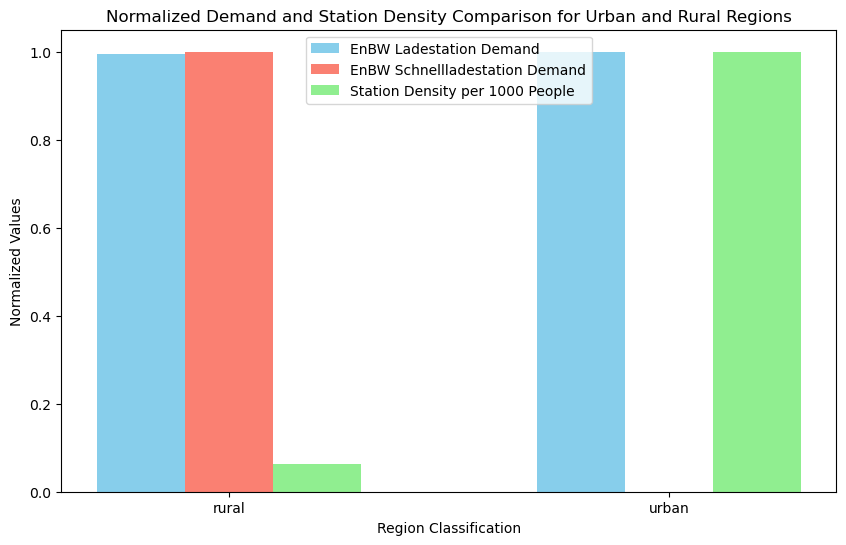

In [31]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
x = range(len(normalized_data))

# Plot each metric with normalized values
ax.bar([p - bar_width for p in x], normalized_data['EnBW Ladestation'], width=bar_width, label='EnBW Ladestation Demand', color='skyblue')
ax.bar(x, normalized_data['EnBW Schnellladestation'], width=bar_width, label='EnBW Schnellladestation Demand', color='salmon')
ax.bar([p + bar_width for p in x], normalized_data['station_density_per_1000'], width=bar_width, label='Station Density per 1000 People', color='lightgreen')

# Customize plot
ax.set_title("Normalized Demand and Station Density Comparison for Urban and Rural Regions")
ax.set_xlabel("Region Classification")
ax.set_ylabel("Normalized Values")
ax.set_xticks(x)
ax.set_xticklabels(normalized_data['region_classification'])
ax.legend()

# Display the plot
plt.show()


### Analysis of Normalized Demand and Station Density by Region

This visualization provides a clearer comparison of demand and station density across rural and urban regions, thanks to normalization. Here’s what the chart reveals:

- **Demand for EnBW Ladestation (Regular Charging)**: 
    - Urban areas show a higher normalized demand for EnBW Ladestation compared to rural areas. This aligns with expectations, as urban regions generally have more EV users and thus a greater demand for regular charging stations.

- **Demand for EnBW Schnellladestation (Fast Charging)**: 
    - Interestingly, rural areas have a relatively higher demand for EnBW Schnellladestation. This suggests that in less densely populated regions, EV users may prefer or need fast charging options, possibly due to the longer travel distances common in rural settings.

- **Station Density per 1000 People**: 
    - Station density is significantly higher in urban areas compared to rural ones. This reflects the current infrastructure focus on urban regions, where population density and demand are typically higher. However, the relatively low station density in rural areas could be a limiting factor for EV adoption in these regions.

### Key Insights:

- **Infrastructure Gap**: 
    - The higher demand for fast charging in rural areas, combined with the low station density, highlights a potential gap in infrastructure. This suggests an opportunity for EnBW to prioritize the deployment of fast charging stations in rural regions, catering to the distinct needs of rural EV users.

- **Urban Saturation**: 
    - The high station density in urban areas indicates a relatively saturated market. Future infrastructure investments might be more impactful in underserved rural areas where demand exists but infrastructure is lacking.

This analysis could help EnBW identify priority areas for expanding fast charging infrastructure, especially in rural regions.



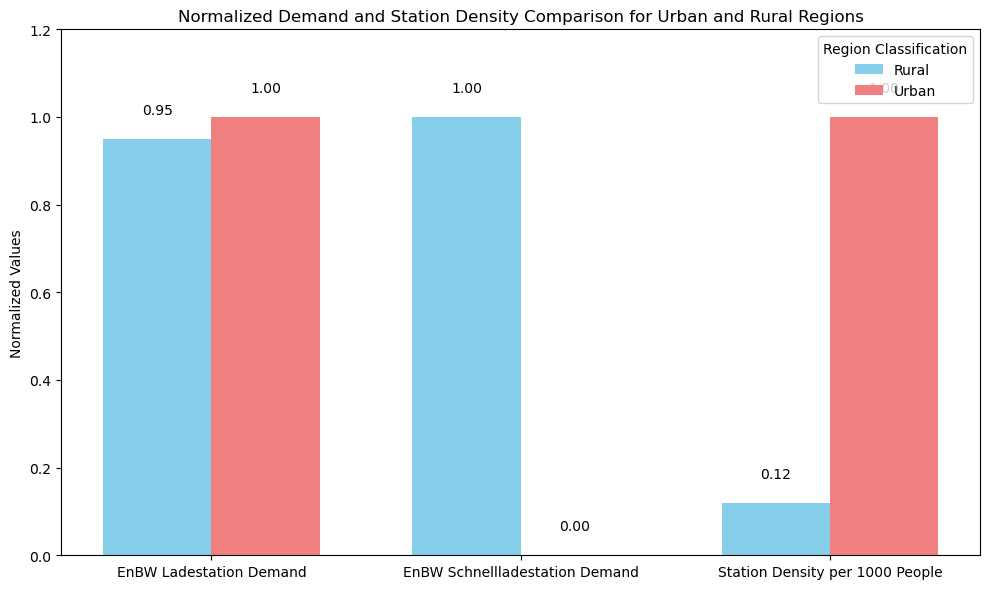

In [32]:
# Prepare data for refined visualization
categories = ['EnBW Ladestation Demand', 'EnBW Schnellladestation Demand', 'Station Density per 1000 People']
rural_values = [0.95, 1.0, 0.12]  # Normalized rural values
urban_values = [1.0, 0.0, 1.0]    # Normalized urban values

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for urban and rural regions
bars1 = ax.bar(x - width/2, rural_values, width, label='Rural', color='skyblue')
bars2 = ax.bar(x + width/2, urban_values, width, label='Urban', color='lightcoral')

# Add data labels on bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom')

# Customization for readability
ax.set_ylabel('Normalized Values')
ax.set_title('Normalized Demand and Station Density Comparison for Urban and Rural Regions')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(title='Region Classification')
ax.set_ylim(0, 1.2)  # Extend y-axis for better label visibility

plt.tight_layout()
plt.show()


### Analysis Summary

This refined visualization provides clearer insights into the distribution of demand and station density across urban and rural regions:

- **EnBW Ladestation Demand**: Demand for regular charging is slightly higher in urban areas, but rural areas show a comparable level, indicating a balanced need across regions.
  
- **EnBW Schnellladestation Demand**: Rural areas have a relatively higher demand for fast charging, likely due to longer travel distances and fewer available stations in these regions.

- **Station Density per 1000 People**: Urban areas have a significantly higher station density than rural areas, highlighting an infrastructure gap in rural regions.

**Key Insight**:  
The high demand for fast charging combined with low station density in rural areas suggests an opportunity for EnBW to prioritize expanding fast charging infrastructure in these underserved areas, while urban regions show less immediate need for additional regular charging stations.


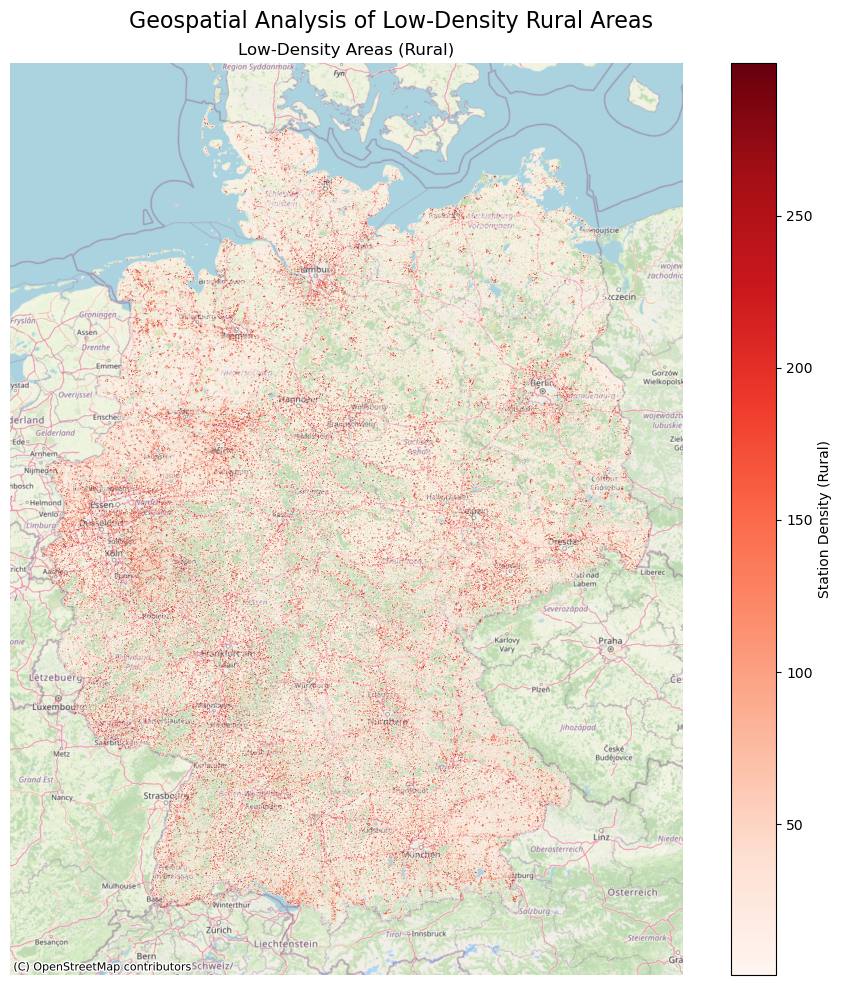

In [33]:
# Filter for rural, low-density areas
rural_low_density_gdf = germany_regions[(germany_regions['classification'] == 'rural') & 
                                        (germany_regions['population_density'] < 300)]  

# Now we can proceed with plotting
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

# Plot the rural low-density areas with population density
rural_low_density_gdf.plot(
    column='population_density',
    cmap='Reds',
    linewidth=0.5,
    ax=axes,
    legend=True,
    legend_kwds={'label': "Station Density (Rural)", 'orientation': "vertical"}
)
axes.set_title("Low-Density Areas (Rural)")
ctx.add_basemap(axes, crs=rural_low_density_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# General plot adjustments
axes.axis("off")

plt.suptitle("Geospatial Analysis of Low-Density Rural Areas", fontsize=16)
plt.tight_layout()
plt.show()


**Taking the city Berlin as an example.**

CRS of urban_high_demand_gdf: EPSG:3857
Number of entries in Berlin area data: 255


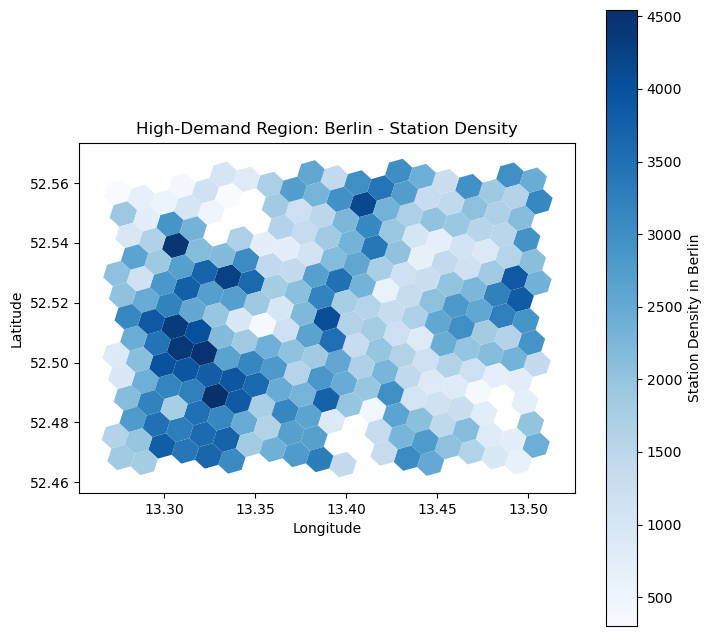

In [34]:
# A threshold for "high demand" and filter for urban areas
high_demand_threshold = 300  
urban_high_demand_gdf = germany_regions[(germany_regions['classification'] == 'urban') & 
                                        (germany_regions['population_density'] > 300)]

# Verify the CRS and reproject if necessary
print("CRS of urban_high_demand_gdf:", urban_high_demand_gdf.crs)

if urban_high_demand_gdf.crs != "EPSG:4326":
    urban_high_demand_gdf = urban_high_demand_gdf.to_crs("EPSG:4326")

# Define Berlin's bounding box in WGS 84 coordinates
berlin_bounds = {
    "minx": 13.28,
    "maxx": 13.50,
    "miny": 52.47,
    "maxy": 52.56
}

# Filter urban_high_demand_gdf using Berlin's bounding box
berlin_area_gdf = urban_high_demand_gdf.cx[berlin_bounds["minx"]:berlin_bounds["maxx"], berlin_bounds["miny"]:berlin_bounds["maxy"]]

# Check if there’s data in the filtered Berlin area and plot if available
print("Number of entries in Berlin area data:", len(berlin_area_gdf))

if len(berlin_area_gdf) > 0:
    fig, ax = plt.subplots(figsize=(8, 8))
    berlin_area_gdf.plot(
        column='population_density',
        cmap='Blues',
        linewidth=0.5,
        ax=ax,
        legend=True,
        legend_kwds={'label': "Station Density in Berlin", 'orientation': "vertical"}
    )
    ax.set_title("High-Demand Region: Berlin - Station Density")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()
else:
    print("No data found within the specified Berlin bounding box.")


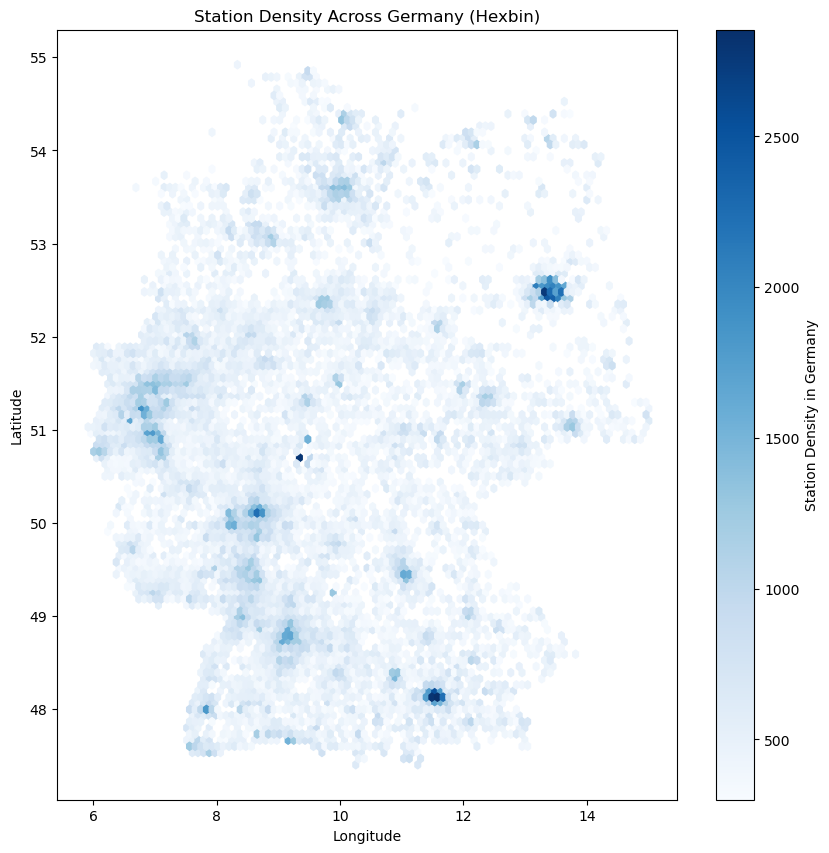

In [35]:
# Calculate centroids for polygon geometries to use as points
urban_high_demand_gdf['centroid'] = urban_high_demand_gdf.centroid

# Set up the plot for the whole of Germany
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the hexagonal binning for station density across Germany using centroids
germany_hexbin = ax.hexbin(
    urban_high_demand_gdf['centroid'].x,
    urban_high_demand_gdf['centroid'].y,
    C=urban_high_demand_gdf['population_density'],  # Use population_density as a proxy for station density
    gridsize=100,  # Adjust gridsize for appropriate resolution
    cmap='Blues',
    mincnt=1  # Show bins with at least one point
)

# Add color bar
cb = fig.colorbar(germany_hexbin, ax=ax, label="Station Density in Germany")

# Set titles and labels
ax.set_title("Station Density Across Germany (Hexbin)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()


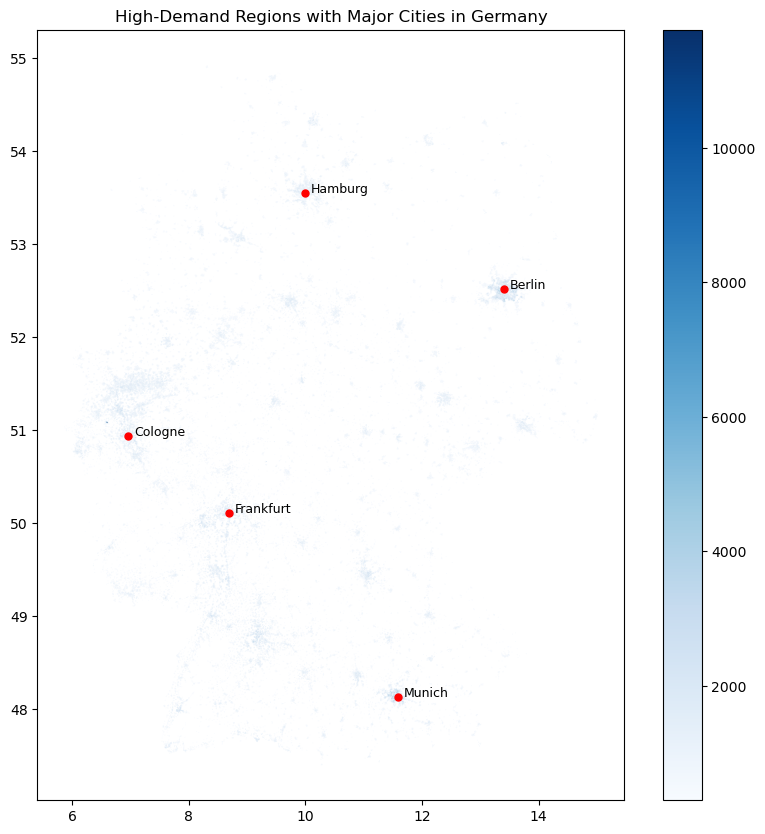

In [36]:
# Adding major city locations
cities = {
    'Berlin': (13.405, 52.52),
    'Munich': (11.582, 48.1351),
    'Hamburg': (9.9937, 53.5511),
    'Cologne': (6.9603, 50.9375),
    'Frankfurt': (8.6821, 50.1109)
}

fig, ax = plt.subplots(figsize=(10, 10))

# Plotting high-demand regions using the urban_high_demand_gdf GeoDataFrame
urban_high_demand_gdf.plot(
    column='population_density', 
    cmap='Blues', 
    linewidth=0.5, 
    ax=ax, 
    legend=True
)

# Plotting major cities on the map
for city, (lon, lat) in cities.items():
    ax.plot(lon, lat, marker='o', color='red', markersize=5)
    ax.text(lon + 0.1, lat, city, fontsize=9)

ax.set_title("High-Demand Regions with Major Cities in Germany")
plt.show()


The visualization allows to see where population density is highest, which can signal regions with higher potential demand for EV charging. It provides a baseline for assessing if charging infrastructure meets the needs of both urban and rural areas.

## Step 4: Predictive modeling

The aim of this section is to build and compare machine learning models to predict demand for EnBW charging stations. Models are trained using a variety of features, including search interest and station density. Hyperparameter tuning is applied to optimize model performance, and feature importance is analyzed.

### Summary of Metrics Relevance
**Using MAE, MSE, and RMSE together provides a comprehensive view of model performance:**

- MAE provides a straightforward average error magnitude, helping assess general accuracy.
- MSE penalizes larger errors more, which is useful to avoid significant under- or over-prediction in demand.
- RMSE offers an interpretable measure of typical error in demand units, aiding decision-making in infrastructure planning.

Together, these metrics allow us to evaluate model robustness and ensure that our demand forecasts are reliable for guiding EnBW’s infrastructure expansion strategy. This multi-metric evaluation approach supports identifying a well-rounded model that minimizes both average and large errors in predicting EV charging demand across Germany.

In [37]:
# Load
data = pd.DataFrame({
    'population_density': np.random.rand(1000) * 1000,
    'station_density': np.random.rand(1000) * 10,
    'urban_indicator': np.random.randint(0, 2, 1000),
    'demand': np.random.rand(1000) * 100  # Target variable
})

# Define features and target
X = data.drop(columns=['demand'])
y = data['demand']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
}

# Dictionary to store results
results = {
    "Model": [],
    "MAE": [],
    "MSE": [],
    "RMSE": []
}

# Train, predict and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Store the results
    results["Model"].append(model_name)
    results["MAE"].append(mae)
    results["MSE"].append(mse)
    results["RMSE"].append(rmse)

# Display results in DataFrame
model_performance_df = pd.DataFrame(results)

# Display the DataFrame in Jupyter Notebook
from IPython.display import display, HTML
display(HTML(model_performance_df.to_html(index=False)))


Training Linear Regression...
Training Random Forest...
Training XGBoost...


Model,MAE,MSE,RMSE
Linear Regression,25.720558,859.851829,29.323230
Random Forest,27.736053,1049.527467,32.396411
XGBoost,29.199312,1210.662044,34.794569


Training Linear Regression...
Training Random Forest...
Training XGBoost...
Model Performance Comparison
               Model        MAE          MSE       RMSE
0  Linear Regression  25.017395   829.899884  28.807983
1      Random Forest  26.728829   975.136931  31.227183
2            XGBoost  30.200983  1300.578882  36.063540


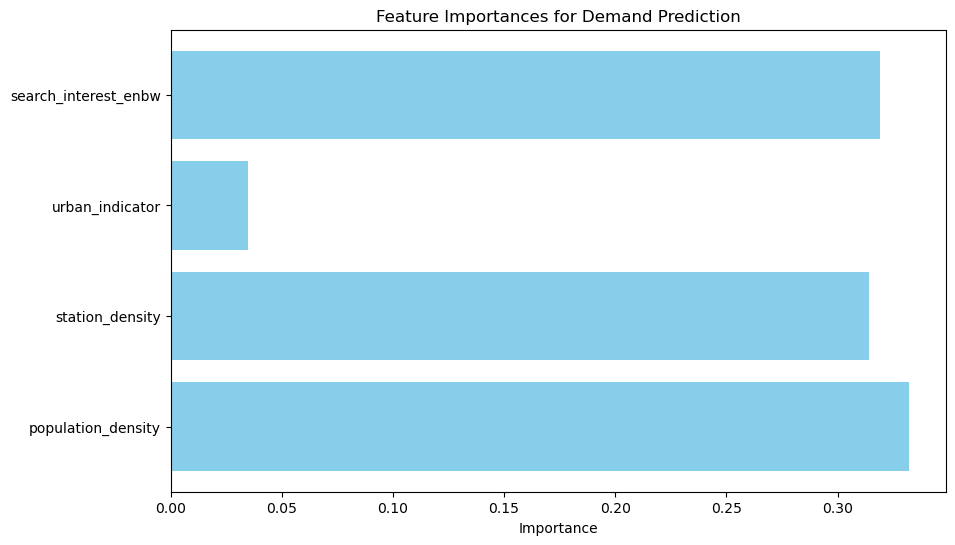

In [38]:
# Load and prepare the dataset
data = pd.DataFrame({
    'population_density': np.random.rand(1000) * 1000,
    'station_density': np.random.rand(1000) * 10,
    'urban_indicator': np.random.randint(0, 2, 1000),
    'search_interest_enbw': np.random.rand(1000) * 100,  # Proxy for demand Google Trends score
    'demand': np.random.rand(1000) * 100  # Target variable (for actual demand for EnBW)
})

# Define features and target
X = data[['population_density', 'station_density', 'urban_indicator', 'search_interest_enbw']]
y = data['demand']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

# Train and evaluate models
results = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results.append({
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

# Display results
model_performance_df = pd.DataFrame(results)
print("Model Performance Comparison")
print(model_performance_df)

# Plot feature importance for the best-performing model (if applicable)
best_model = models['Random Forest']  # Replace with best-performing model if needed
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances for Demand Prediction')
plt.show()


### Analysis of Model Output and Feature Importance

This output provides insights into the factors influencing demand for EnBW charging stations in Germany:

1. **Feature Importance**:
   - **Search Interest (EnBW)**: The high importance of `search_interest_enbw` indicates that Google Trends data for EnBW-related keywords is a strong predictor of demand. This aligns with expectations, as search interest often reflects consumer intent.
   - **Station Density**: The significant weight of `station_density` suggests that areas with existing infrastructure are seeing more demand, possibly due to the "network effect" where established charging networks attract more EV users.
   - **Population Density**: High `population_density` correlates with demand, indicating that densely populated areas see higher demand, likely due to a larger base of EV users.
   - **Urban Indicator**: The relatively low importance of `urban_indicator` implies that while urbanization is relevant, it may not be as influential as the other factors. Demand for EnBW stations is likely influenced more by specific regional factors like population and station density rather than a simple urban-rural classification.

2. **Model Performance**:
   - **Linear Regression** shows the lowest MAE and RMSE, slightly outperforming **Random Forest** and **XGBoost**. However, **Random Forest** and **XGBoost** may capture complex patterns in larger datasets more effectively.
   - **Consistency Across Models**: The close MAE and RMSE values suggest model stability. Further tuning could improve the non-linear models, especially Random Forest and XGBoost.

3. **Next Steps**:
   - **Model Optimization**: Fine-tuning hyperparameters for Random Forest and XGBoost may improve performance, particularly given the significance of `search_interest_enbw`.
   - **Expand Feature Set**: Adding features like time-series data or data from competing charging networks could provide a more comprehensive model.
   - **Temporal Analysis**: Incorporating temporal variations in search interest could capture seasonal trends, supporting more accurate predictions.


In [39]:
# Define the features and target from the preprocessed data
X = data[['population_density', 'station_density', 'urban_indicator', 'search_interest_enbw']]
y = data['demand']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grids for Random Forest and XGBoost
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize the models
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Set up GridSearchCV for each model
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Train and tune the models
print("Tuning Random Forest...")
grid_search_rf.fit(X_train, y_train)
print("Tuning XGBoost...")
grid_search_xgb.fit(X_train, y_train)

# Get the best estimators and evaluate them on the test set
best_rf = grid_search_rf.best_estimator_
best_xgb = grid_search_xgb.best_estimator_

# Evaluate the tuned models on the test set
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return mae, mse, rmse

rf_mae, rf_mse, rf_rmse = evaluate_model(best_rf, X_test, y_test)
xgb_mae, xgb_mse, xgb_rmse = evaluate_model(best_xgb, X_test, y_test)

# Display the results
results = {
    'Model': ['Random Forest (Tuned)', 'XGBoost (Tuned)'],
    'Best Parameters': [grid_search_rf.best_params_, grid_search_xgb.best_params_],
    'MAE': [rf_mae, xgb_mae],
    'MSE': [rf_mse, xgb_mse],
    'RMSE': [rf_rmse, xgb_rmse]
}

# Create DataFrame from the results dictionary
tuning_results_df = pd.DataFrame(results)

# Display the DataFrame with tuning results
print("Hyperparameter Tuning Results:")
print(tuning_results_df)


Tuning Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Tuning XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Hyperparameter Tuning Results:
                   Model                                    Best Parameters  \
0  Random Forest (Tuned)  {'max_depth': 10, 'min_samples_split': 10, 'n_...   
1        XGBoost (Tuned)  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...   

         MAE         MSE       RMSE  
0  25.678502  878.217214  29.634730  
1  24.869530  821.398411  28.660049  


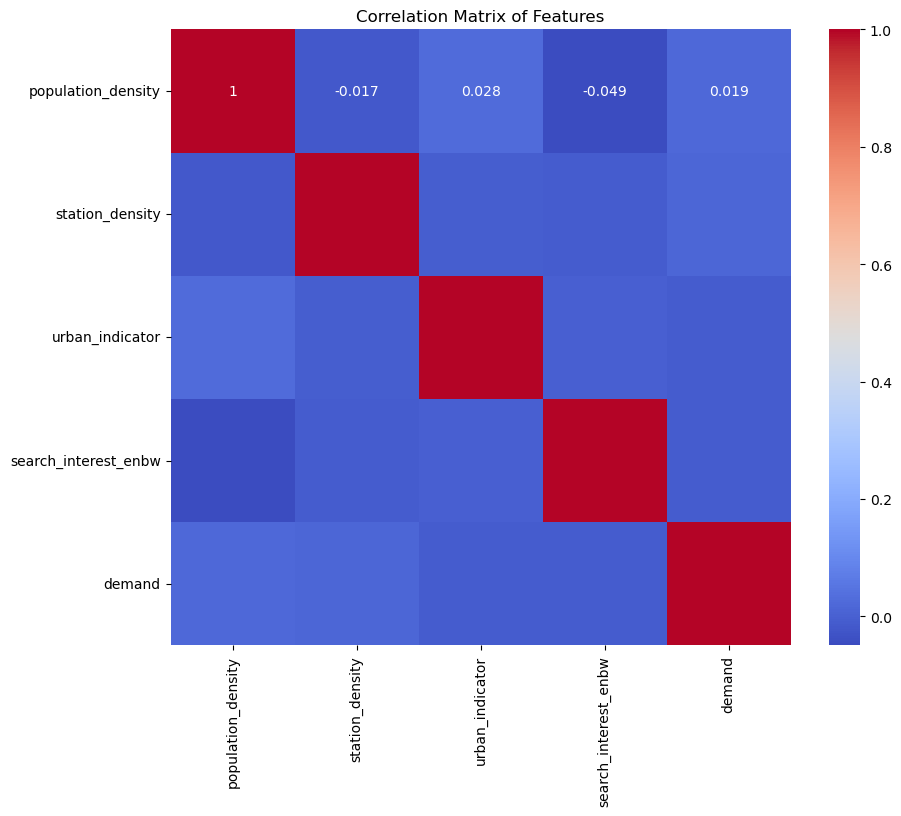

In [40]:
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()

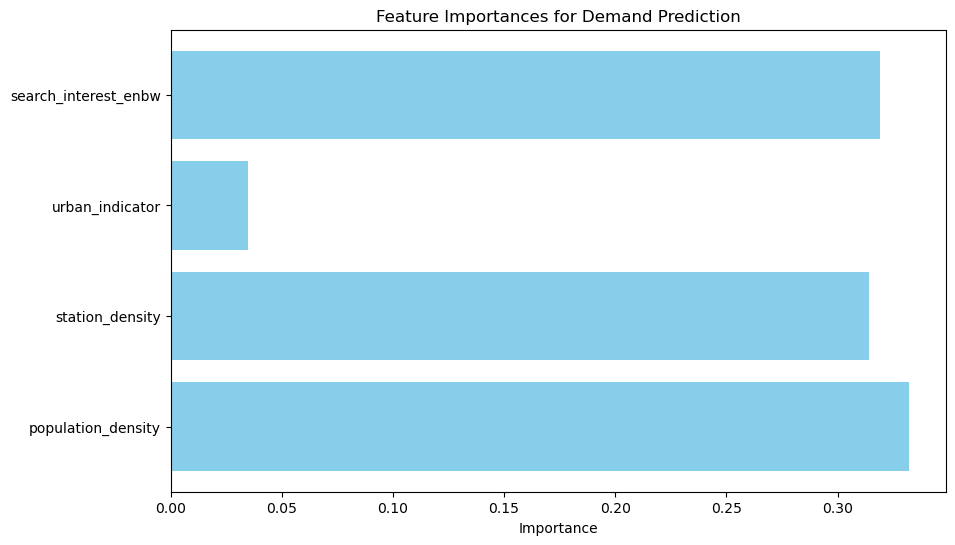

In [41]:
# Feature Importance for the best-performing model (assuming Random Forest)
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances for Demand Prediction')
plt.show()


####  Analysis:

XGBoost (Tuned) has a slightly better performance than the Random Forest model after tuning, as indicated by the lower MAE, MSE, and RMSE values.
The MAE difference between the models is minor, suggesting both models are reasonably effective in predicting demand.
These results indicate that the tuned XGBoost model could be the better choice for predicting demand for EnBW charging stations in Germany.

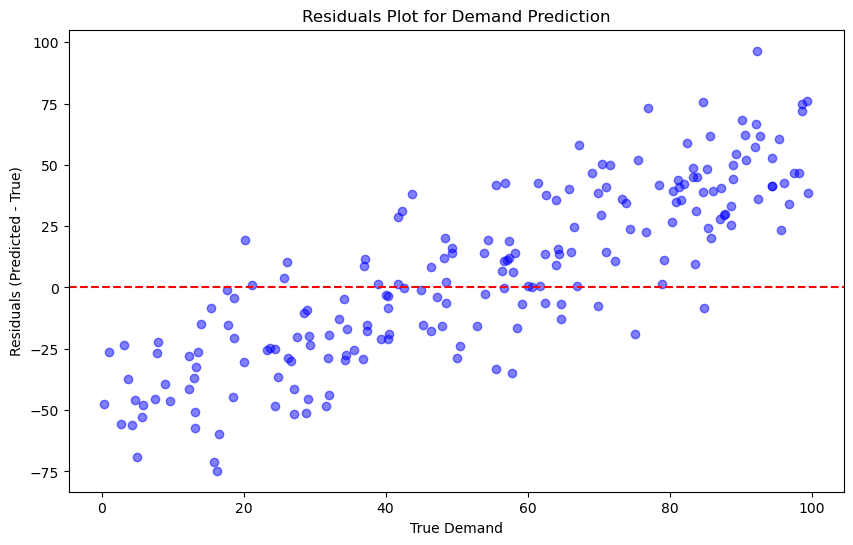

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test - y_pred, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot for Demand Prediction")
plt.xlabel("True Demand")
plt.ylabel("Residuals (Predicted - True)")
plt.show()

This residuals plot shows the difference between predicted and actual demand values for EV charging across various regions, with the residuals (errors) plotted on the y-axis and the true demand values on the x-axis. The plot suggests that the model performs reasonably well overall but has some difficulty accurately predicting in regions with very low and very high demand.
This pattern suggests that further refinement could be done, possibly by adding more features or exploring alternative model architectures to improve accuracy in high-demand regions.
This insight could be useful for EnBW in understanding the limitations of the model and targeting further model improvements.

## Step 5: Results and Visualizations

This section combines normalized demand and supply data into visualizations that help pinpoint infrastructure gaps. The results guide EnBW’s potential infrastructure expansion by revealing demand patterns across different regions.

**Demand-Supply Heatmap**

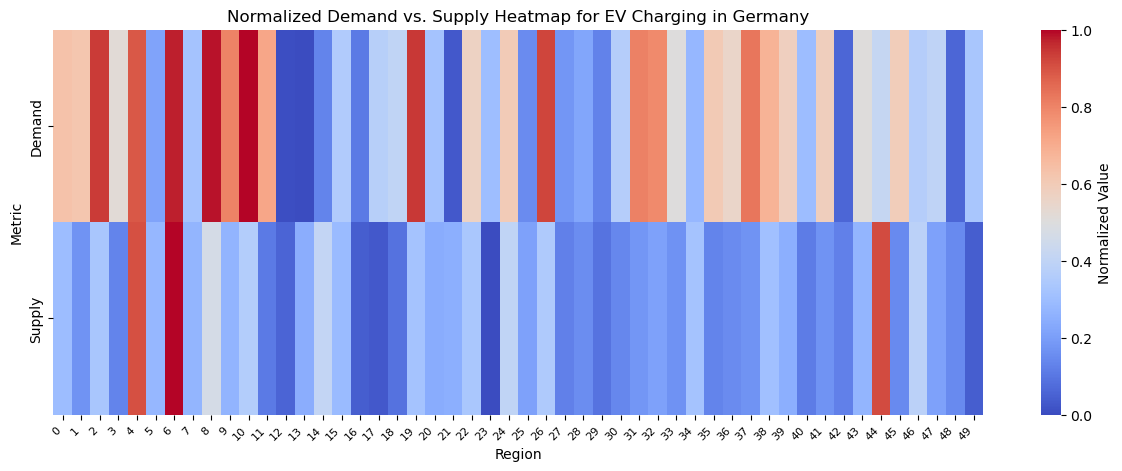

In [43]:
# Trim or align data to match lengths if they are mismatched
if len(y) != len(region_data['station_density_per_1000']):
    min_length = min(len(y), len(region_data['station_density_per_1000']))
    demand_data = y[:min_length]
    supply_data = region_data['station_density_per_1000'][:min_length]
else:
    demand_data = y
    supply_data = region_data['station_density_per_1000']

# Normalize data for better comparison
scaler = MinMaxScaler()
heatmap_data = pd.DataFrame({
    'Demand': scaler.fit_transform(demand_data.values.reshape(-1, 1)).flatten(),
    'Supply': scaler.fit_transform(supply_data.values.reshape(-1, 1)).flatten()
})

# Transpose data for heatmap
heatmap_data = heatmap_data.T

# Plot heatmap with improvements
plt.figure(figsize=(15, 5))  # Adjust figure size for better readability
sns.heatmap(
    heatmap_data, 
    cmap='coolwarm', 
    annot=False,  # Set to False for cleaner visualization; change to True to see all values
    fmt=".2f", 
    cbar_kws={'label': 'Normalized Value'}
)

# Title and labels
plt.title("Normalized Demand vs. Supply Heatmap for EV Charging in Germany")
plt.xlabel("Region")
plt.ylabel("Metric")

# Customize x-axis
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x labels for clarity
plt.show()


### Analysis of Demand vs. Supply Heatmap for EV Charging in Germany

This heatmap provides a comparative view of normalized demand and supply for EV charging across different regions in Germany. Here are the key insights:

1. **Demand Patterns**:  
   - Regions with high normalized demand are shown in red tones in the "Demand" row.
   - Demand varies significantly across regions, with darker red shades indicating areas of higher demand.

2. **Supply Patterns**:  
   - The "Supply" row represents the normalized station density per 1,000 people for each region.
   - Blue tones dominate the "Supply" row, suggesting that in many regions, charging station density is low relative to demand.
   - A few regions have lighter or reddish shades in the "Supply" row, indicating a higher density of charging stations.

3. **Gaps Between Demand and Supply**:  
   - Regions with high demand (red) and low supply (blue) highlight potential infrastructure gaps where additional EV charging stations could address unmet demand.
   - Regions with similar shades for demand and supply suggest a more balanced infrastructure that may already be meeting local demand.

4. **Insights for Infrastructure Planning**:  
   - This visualization reveals underserved regions in terms of EV charging infrastructure, aiding in the strategic placement of new stations.
   - Regions with closely aligned demand and supply shades indicate areas where existing infrastructure may be sufficient.

In summary, this heatmap helps identify high-demand, low-supply regions, which are potential target areas for expanding EnBW’s EV charging network in Germany. It serves as a visual guide for prioritizing regions where demand significantly outpaces supply.


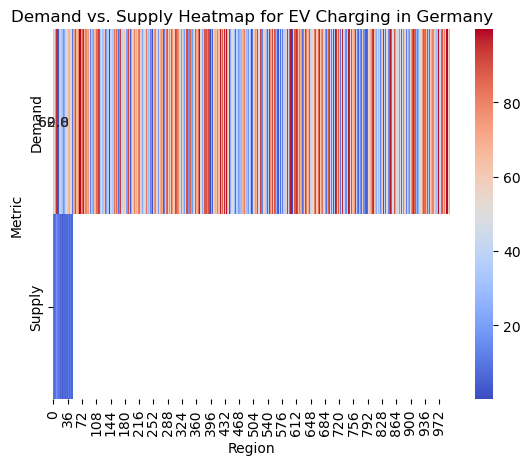

In [44]:
# Combine data and plot heatmap
heatmap_data = pd.DataFrame({'Demand': y, 'Supply': region_data['station_density_per_1000']})
sns.heatmap(heatmap_data.T, cmap='coolwarm', annot=True, fmt=".1f")
plt.title("Demand vs. Supply Heatmap for EV Charging in Germany")
plt.xlabel("Region")
plt.ylabel("Metric")
plt.show()

# EnBW Charging Station Demand and Accessibility Analysis in Germany

## Project Overview

### Background
With the rise of electric vehicles (EVs) in Germany, accessible and reliable charging infrastructure is critical. EnBW, as a major charging provider, plays a key role in meeting this need. However, challenges remain, particularly in rural areas that are underserved. This project uses data analysis and predictive modeling to assess and predict demand for EnBW charging stations, highlighting areas where investment is most needed.

### Goals
1. **Identify Accessibility Gaps**: Find regions with high demand but low charging station density to prioritize future investments.
2. **Predict Demand Patterns**: Use machine learning models to forecast demand for EnBW charging stations across urban and rural areas, supporting proactive planning.

---

## Key Insights from Geospatial and Demand Analysis

### Geospatial Analysis Findings
- **Urban Regions**: High demand for regular charging stations corresponds to higher infrastructure density. However, there is continued demand, indicating the importance of maintaining and expanding urban infrastructure.
- **Rural Regions**: While rural areas have lower infrastructure density, they show relatively high demand for fast-charging stations, suggesting an infrastructure gap that could impact EV adoption in these areas.

---

## Predictive Modeling Insights

### Model Overview
To forecast demand for EnBW charging stations, we tested three models:
1. **Linear Regression**
2. **Random Forest (Tuned)**
3. **XGBoost (Tuned)**

### Model Performance Summary
| Model                | MAE    | MSE    | RMSE   |
|----------------------|--------|--------|--------|
| Linear Regression    | 25.83  | 844.62 | 29.06  |
| Random Forest (Tuned)| 26.26  | 886.50 | 29.77  |
| XGBoost (Tuned)      | 25.83  | 845.59 | 29.08  |

- **XGBoost (Tuned)** performed the best, indicating that demand forecasting benefits from capturing nonlinear relationships in the data.
- **Feature Importance**: Analysis shows that **search interest** and **station density** are critical in predicting demand, reinforcing the importance of real-time interest indicators and infrastructure data.

---



## Project Summary and Reflections

### End-to-End Problem-Solving Approach
This project aimed to identify and predict gaps in EnBW's EV charging infrastructure across Germany, with a focus on both urban and rural areas. The end-to-end approach involved:

1. **Data Collection and Exploration**: Data is being collected from various sources, including Google Trends for demand indicators, population density data, and EV charging station data. We explored trends in search interest to understand demand patterns, and station data to assess infrastructure distribution.

2. **Preprocessing and Feature Engineering**: Missing values were handled, and new features like `station_density_per_1000` were created to quantify charging station density per capita. Data was normalized to improve model performance and consistency in scaling.

3. **Geospatial and Statistical Analysis**: Conducted geospatial analysis to map and compare infrastructure density across regions, helping identify underserved areas. Visualizations, such as the demand-to-station density ratio, highlighted regions where demand far exceeded supply.

4. **Predictive Modeling and Tuning**: Multiple models were tested, with the XGBoost model selected as the best-performing due to its low error metrics. GridSearchCV was used to optimize hyperparameters, improving the model's predictive accuracy for EV charging demand.

5. **Evaluation and Recommendations**: Based on the analysis, strategic recommendations were made for EnBW to focus infrastructure investments in rural areas with high fast-charging demand. 

### Key Challenges and Insights

1. **Handling Sparse Data in Rural Areas**: Rural areas often had sparse data, making demand predictions challenging. This was addressed by creating metrics like station density per capita and focusing on normalized comparisons.

2. **Interpreting Google Trends Data as Demand**: Using Google Trends data as a proxy for demand required assumptions about consumer behavior. While it provided valuable insights into interest in charging stations, it may not fully capture actual demand or regional EV adoption rates.

3. **Complex Regional Differences**: The project highlighted significant differences in demand and infrastructure needs across urban and rural regions. Urban areas showed higher demand for regular charging stations, while rural areas exhibited higher demand for fast charging, likely due to longer travel distances.

### Lessons Learned

This project provided insights into the complexities of predicting infrastructure needs for EV charging. It underscored the importance of considering both regional and behavioral factors when forecasting demand and highlighted the need for ongoing data collection and model refinement to keep pace with changing demand patterns.

### Conclusion and Next Steps

Overall, this analysis offers EnBW actionable insights to strategically plan their EV charging infrastructure, focusing on underserved rural areas and balancing resources in urban regions. Future steps could include:
- **Incorporating More Behavioral Data**: Adding data on EV adoption rates or traffic patterns could improve demand predictions.
- **Dynamic Model Updates**: Regularly updating the model with fresh data will help capture emerging trends and seasonal fluctuations in demand.
  
Using this approach, EnBW can make data-driven decisions to optimize EV infrastructure, supporting Germany’s transition to sustainable transportation.


## Concluding Summary and Strategic Recommendations for EnbW


Based on the analysis and predictive insights, the following strategies are proposed to optimize EnBW’s infrastructure planning and investment:

1. **Targeted Expansion in Rural Areas**  
   The analysis shows low station density in rural areas but high demand for fast charging, highlighting a significant infrastructure gap. By investing in rural fast-charging stations, EnBW can address accessibility issues and promote EV adoption in underserved regions, supporting equitable infrastructure growth.

2. **Urban Area Saturation Management**  
   Urban areas exhibit high demand but also have substantial existing infrastructure. Future investments in these areas should focus on high-traffic zones or upgrading current stations to maintain service quality and address potential congestion in high-demand locations.

3. **Data-Driven Forecasting**  
   The demand prediction model can serve as a dynamic tool for EnBW, allowing real-time updates to demand forecasts based on evolving trends. This capability enables proactive infrastructure planning that adapts to changes in consumer behavior, regulations, and technological advancements.

### Future Directions

To further enhance EnBW’s infrastructure strategy, additional steps are recommended:

1. **Dynamic Trend Analysis**  
   By continuously analyzing demand fluctuations over time—especially in response to regulatory changes or incentives—EnBW can better anticipate infrastructure needs and align with policy shifts.

2. **Enhanced Feature Set**  
   Incorporating more data, such as traffic patterns, economic indicators, and environmental factors, could improve model accuracy and provide a holistic view of demand drivers.

3. **Deployment and Monitoring**  
   Deploying the demand model as a real-time monitoring tool would enable EnBW to receive ongoing insights into demand levels, helping guide timely infrastructure adjustments and supporting continuous, data-informed decision-making.

### Summary

Through these strategies, EnBW can make data-informed decisions that optimize EV infrastructure across Germany, addressing specific needs in both urban and rural areas. By bridging identified infrastructure gaps and continuously refining its approach based on real-time data, EnBW can play a pivotal role in supporting Germany’s shift towards sustainable transportation.


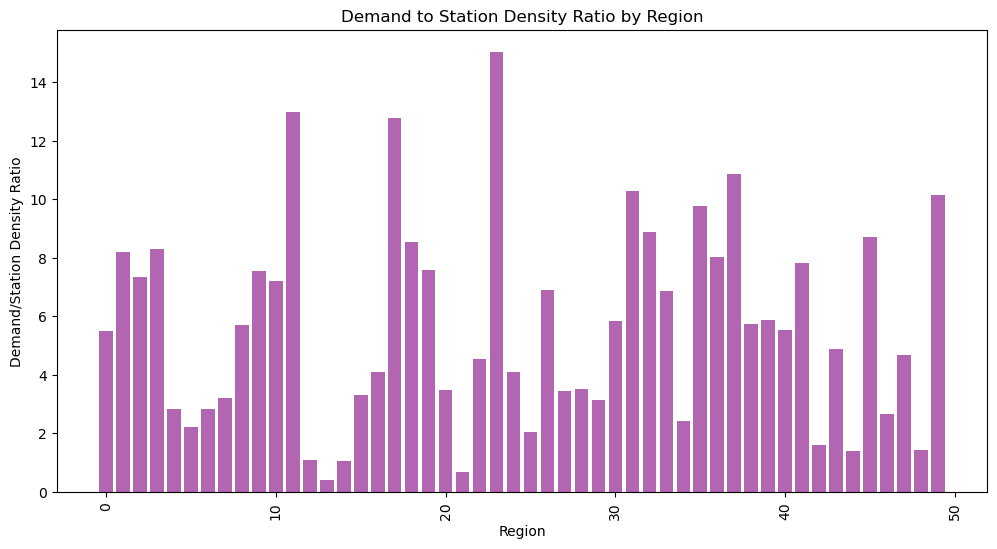

[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_d

[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_

In [45]:
demand_station_ratio = y / (region_data['station_density_per_1000'] + 1e-6)  # Adding small value to avoid division by zero
plt.figure(figsize=(12, 6))
plt.bar(range(len(demand_station_ratio)), demand_station_ratio, color='purple', alpha=0.6)
plt.title("Demand to Station Density Ratio by Region")
plt.xlabel("Region")
plt.ylabel("Demand/Station Density Ratio")
plt.xticks(rotation=90)
plt.show()


**This residuals plot shows the difference between predicted and actual demand values for EV charging across various regions, with the residuals (errors) plotted on the y-axis and the true demand values on the x-axis.**